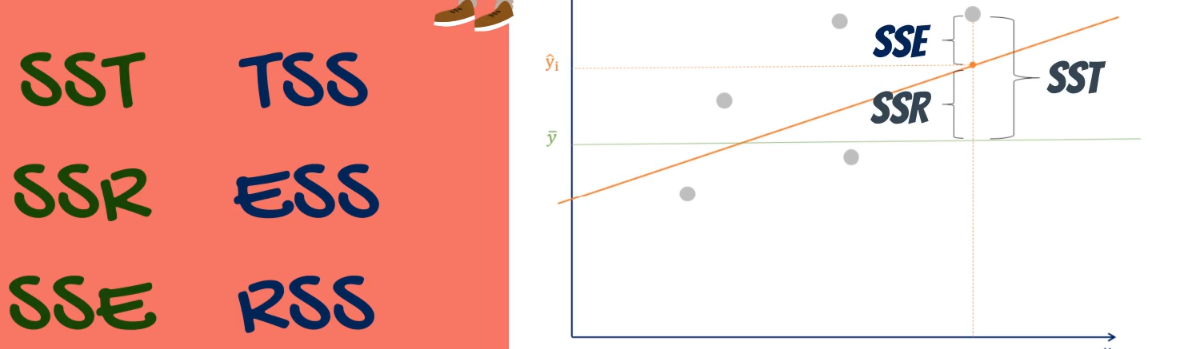

## Importing the relevant libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import itertools
from copy import deepcopy

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from scipy.stats import f, t

np.set_printoptions(precision=15, suppress=False)
sns.set_theme()

## Loading the raw data

In [5]:
df_main = pd.read_csv('cars_dataset.csv')
df = df_main.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [6]:
df.shape

(4345, 9)

## Preprocessing

### Exploring the Descriptive Statistics of the Variables

In [7]:
df.describe(include='all').round(2)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.00,4345,4345.00,4195.00,4345,4345,4345.00,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.75,NaN,161.24,2.79,NaN,NaN,2006.55,NaN
std,NaN,25584.24,NaN,105.71,5.07,NaN,NaN,6.72,NaN
min,NaN,600.00,NaN,0.00,0.60,NaN,NaN,1969.00,NaN
25%,NaN,6999.00,NaN,86.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11500.00,NaN,155.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,230.00,3.00,NaN,NaN,2012.00,NaN


### Dropping the non-important Variables

In [8]:
df = df.drop(['Model'], axis=1)

### Dealing with Missing Values

In [9]:
# Counting the missing values
df.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [10]:
# Dropping missing values (and their respective row)
df.dropna(axis=0, ignore_index=True, inplace=True)

In [11]:
# Counting the missing values
df.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
dtype: int64

In [12]:
df.shape

(4025, 8)

### Exploring the Distribution and Dealing with Outliers

#### Price

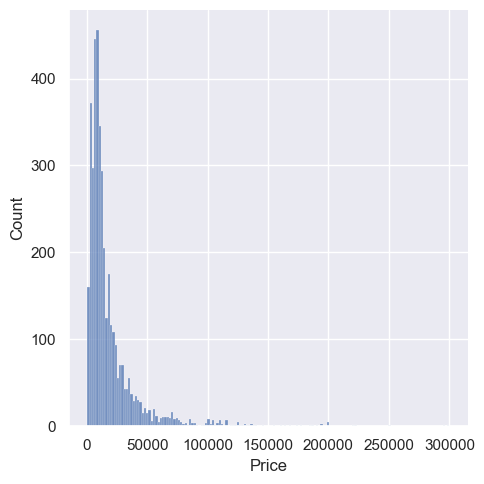

In [13]:
# "Price" feature plot
sns.displot(df['Price'])
plt.show()

In [14]:
# Removing outliers from "Price" Feature
q = df['Price'].quantile(0.99)
df = df[df['Price']<q]

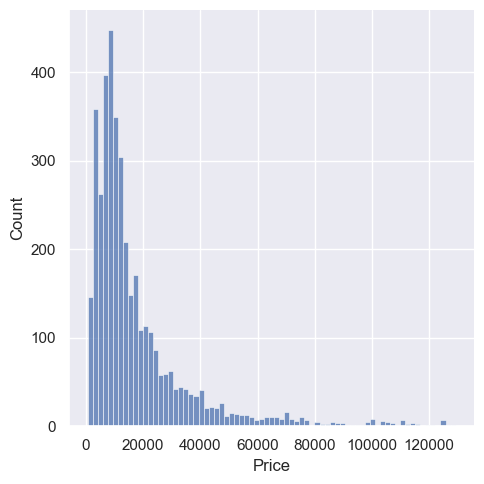

In [15]:
# "Price" feature plot
sns.displot(df['Price'])
plt.show()

#### Mileage

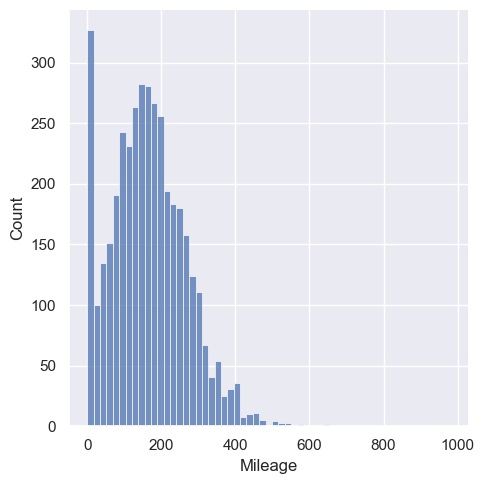

In [16]:
# "Mileage" feature plot
sns.displot(df['Mileage'])
plt.show()

In [17]:
# Removing outliers from "Mileage" feature
q = df['Mileage'].quantile(0.99)
df = df[df['Mileage']<q]

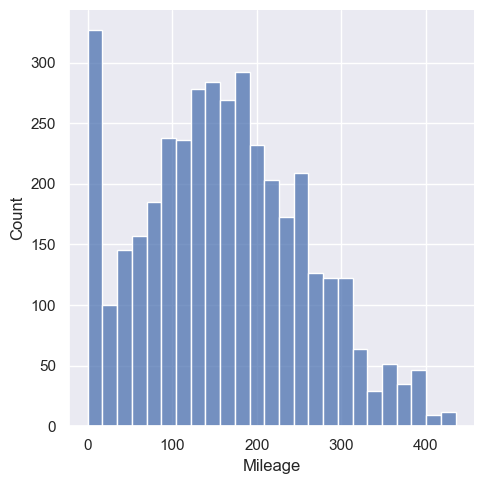

In [18]:
# "Mileage" feature plot
sns.displot(df['Mileage'])
plt.show()

#### EngineV

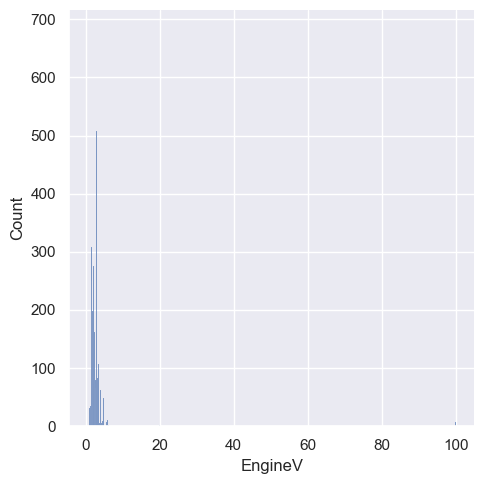

In [19]:
# "EngiveV" feature plot
sns.displot(df['EngineV'])
plt.show()

In [20]:
# Removing outliers from "EngiveV" feature
df = df[df['EngineV']<6.5]

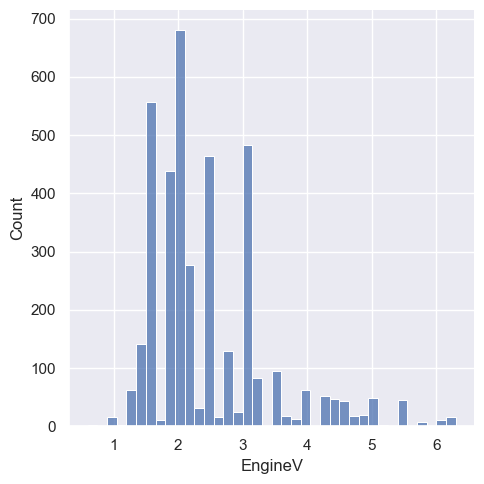

In [21]:
# "EngiveV" feature plot
sns.displot(df['EngineV'])
plt.show()

#### Year

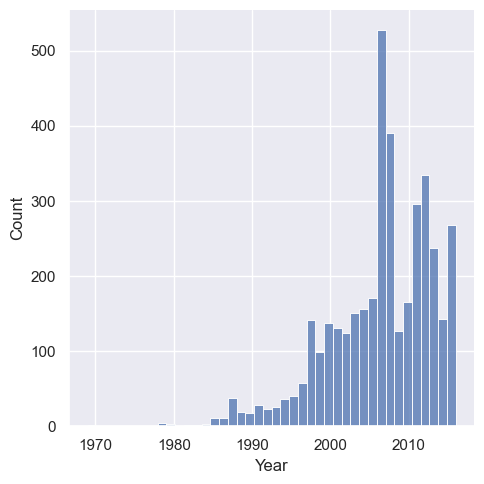

In [22]:
# "Year" feature plot
sns.displot(df['Year'])
plt.show()

In [23]:
# Removing outliers from "Year" feature
q = df['Year'].quantile(0.01)
df = df[df['Year']>q]

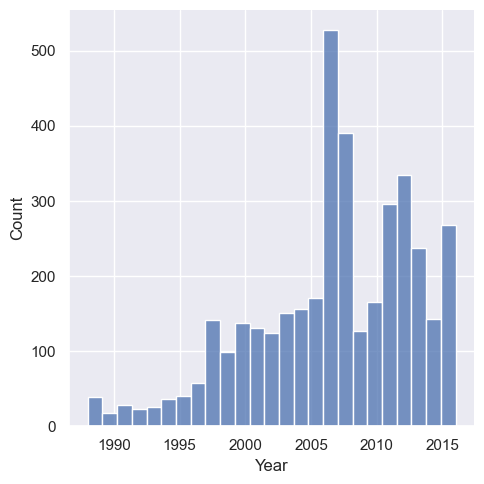

In [24]:
# "Year" feature plot
sns.displot(df['Year'])
plt.show()

In [25]:
# Resets the index
df.reset_index(drop=True, inplace=True)

## Categorizing Variables

In [26]:
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011


In [27]:
# Count unique values per feature
df.nunique()

Brand             7
Price           849
Body              6
Mileage         377
EngineV          55
Engine Type       4
Registration      2
Year             29
dtype: int64

In [28]:
# Initialize the One Hot Encoder
onehot_encoder = ce.OneHotEncoder(use_cat_names=True)

# Fit and transform the data
df_encoded = onehot_encoder.fit_transform(df)

In [29]:
# Encoded data,
## Note: the "reference level has not been assigned nor dropped" 
df_encoded.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Price,Body_sedan,Body_van,...,Body_hatch,Mileage,EngineV,Engine Type_Petrol,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Registration_yes,Registration_no,Year
0,1,0,0,0,0,0,0,4200.0,1,0,...,0,277,2.0,1,0,0,0,1,0,1991
1,0,1,0,0,0,0,0,7900.0,0,1,...,0,427,2.9,0,1,0,0,1,0,1999
2,0,1,0,0,0,0,0,13300.0,1,0,...,0,358,5.0,0,0,1,0,1,0,2003
3,0,0,1,0,0,0,0,23000.0,0,0,...,0,240,4.2,1,0,0,0,1,0,2007
4,0,0,0,1,0,0,0,18300.0,0,0,...,0,120,2.0,1,0,0,0,1,0,2011


In [30]:
# Encoded columns
df_encoded.columns

Index(['Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Audi', 'Brand_Toyota',
       'Brand_Renault', 'Brand_Volkswagen', 'Brand_Mitsubishi', 'Price',
       'Body_sedan', 'Body_van', 'Body_crossover', 'Body_vagon', 'Body_other',
       'Body_hatch', 'Mileage', 'EngineV', 'Engine Type_Petrol',
       'Engine Type_Diesel', 'Engine Type_Gas', 'Engine Type_Other',
       'Registration_yes', 'Registration_no', 'Year'],
      dtype='object')

In [31]:
# Encoded data-types
df_encoded.dtypes

Brand_BMW                int64
Brand_Mercedes-Benz      int64
Brand_Audi               int64
Brand_Toyota             int64
Brand_Renault            int64
Brand_Volkswagen         int64
Brand_Mitsubishi         int64
Price                  float64
Body_sedan               int64
Body_van                 int64
Body_crossover           int64
Body_vagon               int64
Body_other               int64
Body_hatch               int64
Mileage                  int64
EngineV                float64
Engine Type_Petrol       int64
Engine Type_Diesel       int64
Engine Type_Gas          int64
Engine Type_Other        int64
Registration_yes         int64
Registration_no          int64
Year                     int64
dtype: object

In [32]:
# Encoded number of unique values
df_encoded.nunique()

Brand_BMW                2
Brand_Mercedes-Benz      2
Brand_Audi               2
Brand_Toyota             2
Brand_Renault            2
Brand_Volkswagen         2
Brand_Mitsubishi         2
Price                  849
Body_sedan               2
Body_van                 2
Body_crossover           2
Body_vagon               2
Body_other               2
Body_hatch               2
Mileage                377
EngineV                 55
Engine Type_Petrol       2
Engine Type_Diesel       2
Engine Type_Gas          2
Engine Type_Other        2
Registration_yes         2
Registration_no          2
Year                    29
dtype: int64

## Scaling 

* Columns to scale "Mileage", "EngineV"

In [33]:
# "Mileage"
mean_mileage = df_encoded["Mileage"].mean()
std_mileage = df_encoded["Mileage"].std()
df_encoded["Mileage"] = (df_encoded["Mileage"] - mean_mileage) / std_mileage

In [34]:
# "EngineV"
mean_enginev = df_encoded["EngineV"].mean()
std_enginev = df_encoded["EngineV"].std()
df_encoded["EngineV"] = (df_encoded["EngineV"] - mean_enginev) / std_enginev

In [35]:
# Scaled columns
df_encoded[["Mileage", "EngineV"]].head()

,Mileage,EngineV
0,1.217750,-0.474463
1,2.786242,0.473537
2,2.064736,2.685539
3,0.830856,1.842872
4,-0.423938,-0.474463


## Checking the OLS assumptions

In [36]:
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

### Linearity

In [37]:
# Identify boolean-like columns (columns with only 0 and 1)
X_boolean = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]

# Exclude boolean-like columns and select only continuous columns
X_nonboolean = X.drop(columns=X_boolean, axis=0)

# Display the new DataFrame
print(X_nonboolean)

       Mileage   EngineV  Year
0     1.217750 -0.474463  1991
1     2.786242  0.473537  1999
2     2.064736  2.685539  2003
3     0.830856  1.842872  2007
4    -0.423938 -0.474463  2011
...        ...       ...   ...
3862  0.025697  0.052204  2008
3863 -1.312749 -0.895797  2014
3864 -1.584621  0.578871  2014
3865 -1.668274  1.105538  1999
3866 -0.382111 -0.474463  2013

[3867 rows x 3 columns]


In [38]:
# Plots the predicted values (b0 intercept + b1 slope) per non-boolean feature
def regression_plot(x, y):
    """ Prints the plot of the predicted values (b0 intercept + b1 slope)

    Arguments:
        x -- feature (1)
        y -- target variable
    """
    b1_slope, b0_intercept = np.polyfit(x, y, 1)
    y_pred = b0_intercept + x * b1_slope

    plt.figure(figsize=(6,3))
    plt.title(x.name + " and " + y.name)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red', label='Regression Line')
    plt.show()

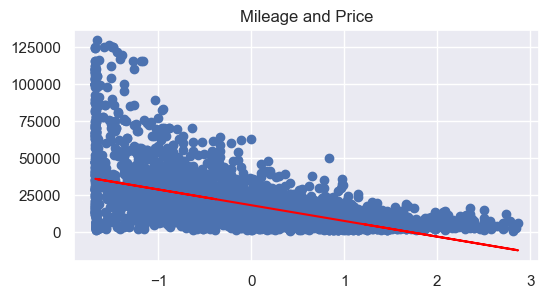

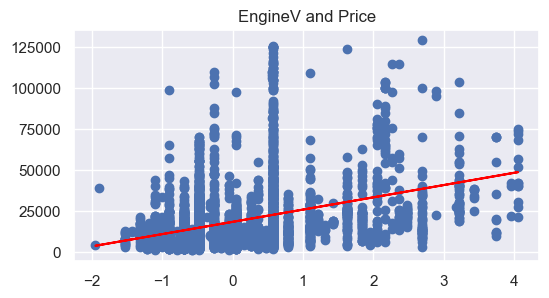

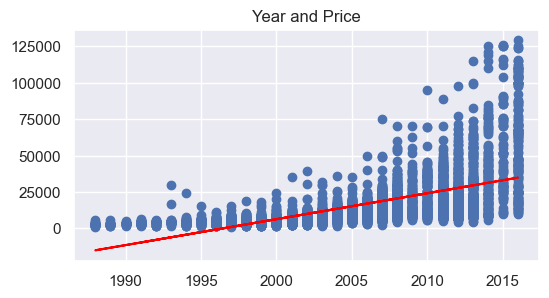

In [39]:
for col in X_nonboolean.columns:
    regression_plot(X[col], y)

In [40]:
# Natural Logarithm: euler's number as base number (2.71828)
price_log = pd.Series(np.log(y), name="Price_log")

In [41]:
price_log.head()

0     8.342840
1     8.974618
2     9.495519
3    10.043249
4     9.814656
Name: Price_log, dtype: float64

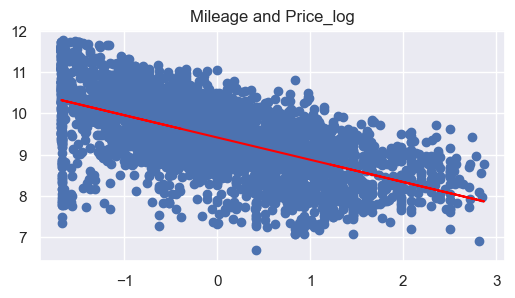

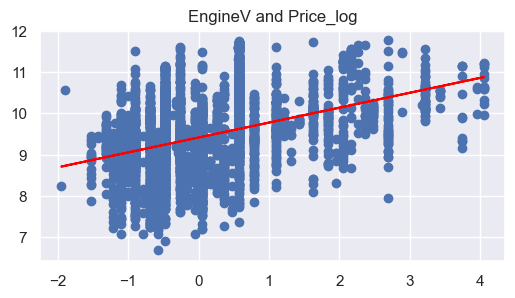

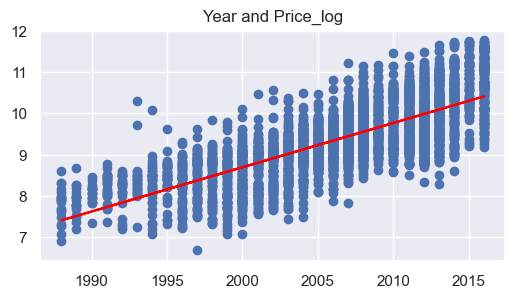

In [42]:
for col in X_nonboolean.columns:
    regression_plot(X[col], price_log)

In [43]:
# Log of Price (y)
y = price_log

In [44]:
del price_log

### No Endogeneity / Exogeneity

In [45]:
x = sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, x).fit()
# Extract residuals
residuals = model.resid
X["residuals"] = residuals

In [46]:
# Correlation matrix between residuals + feature
resid_corr = X.corr().loc[["residuals"], :"Year"] 
resid_corr

,Brand_BMW,Brand_Mercedes-Benz,Brand_Audi,Brand_Toyota,Brand_Renault,Brand_Volkswagen,Brand_Mitsubishi,Body_sedan,Body_van,Body_crossover,...,Body_hatch,Mileage,EngineV,Engine Type_Petrol,Engine Type_Diesel,Engine Type_Gas,Engine Type_Other,Registration_yes,Registration_no,Year
residuals,1.512965e-13,2.588840e-14,1.438728e-13,-6.079483e-14,-1.215710e-13,-1.217201e-13,-4.121245e-15,1.268079e-14,-7.518718e-14,-1.086607e-14,...,2.814302e-14,4.641281e-14,7.117570e-14,8.471279e-14,-2.828134e-14,-6.884431e-14,-1.385704e-14,2.084343e-14,-2.083185e-14,-8.432876e-14


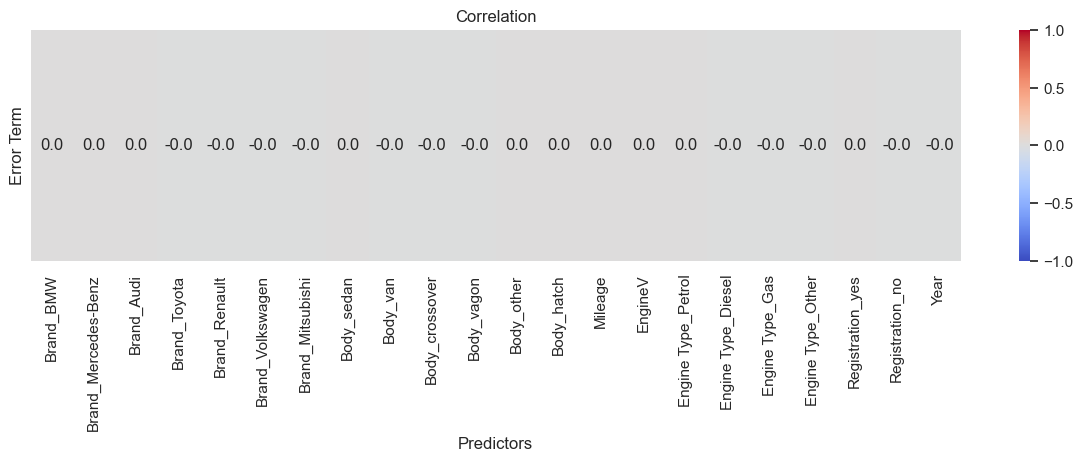

In [47]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15,3))
sns.heatmap(resid_corr, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            annot_kws={"rotation": 0},
            fmt=".1f"
)

plt.title('Correlation')
plt.ylabel('Error Term')
plt.yticks([])
plt.xlabel('Predictors')
plt.xticks(rotation=90)
plt.show()

In [48]:
X.drop("residuals", axis=1, inplace=True)

### Homoscedasticity / Constant Error Variance / No Heteroscedasticity

In [49]:
# Perform Breusch-Pagan test to check for homocedasticity
bp_test = het_breuschpagan(residuals, model.model.exog) 

# Get the p-value
p_value = bp_test[1] 

# Print the results
print(f"Breusch-Pagan Test p-value for the Model: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis of homoscedasticity.")
    print("There is evidence of heteroscedasticity.")
    print(f"The model is significant.\n")
else:
    print("Fail to reject the null hypothesis of homoscedasticity.")
    print("There is no evidence of heteroscedasticity.")
    print(f"The model is insignificant.\n")

Breusch-Pagan Test p-value for the Model: 3.458194952154281e-29
Reject the null hypothesis of homoscedasticity.
There is evidence of heteroscedasticity.
The model is significant.



### No Autocorrelation / Independant Error Terms / No Serial Correlation

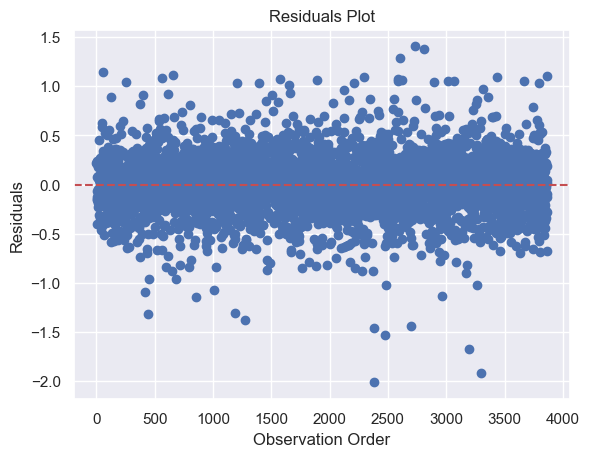

In [50]:
plt.scatter(residuals.index, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Observation Order")
plt.ylabel("Residuals")
plt.show()

In [51]:
# Range from 0 to 4, closer to 2 means no auto-correlation
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_statistic}")

Durbin-Watson Statistic: 2.0529599168916333


### No Multicollinearity

#### Correlation

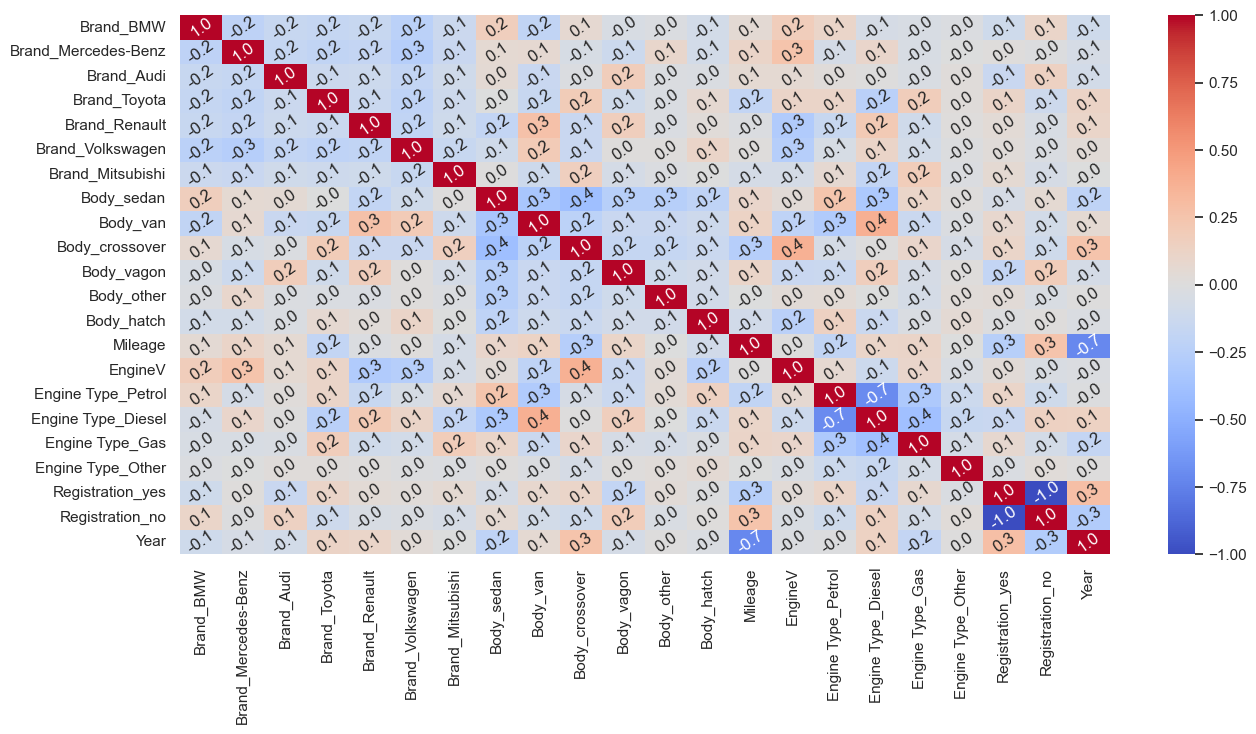

In [52]:
# Correlation matrix between features
corr_matrix = X.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, 
            annot=True,
            annot_kws={"rotation": 35},
            cmap='coolwarm', 
            fmt=".1f")
plt.xticks(rotation=90)
plt.show()

#### VIF (Variance inflation factor)

* VIF = 1: No multicollinearity.
* 1 < VIF < 5: Moderate correlation (usually acceptable).
* VIF ≥ 5 (or 10): High multicollinearity (may need to address it).

In [53]:
# Drop "Year" as it is highly correlated to "Mileage"
drop_col = ["Year"]

# Create a copy dataframe to test different features drop
X_corr_test = deepcopy(X)
X_corr_test.drop(columns=drop_col, axis=1, inplace=True)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_corr_test.columns
vif_data["VIF"] = [variance_inflation_factor(X_corr_test.values, i) for i in range(X_corr_test.shape[1])]
print(vif_data)

c:\Users\aldan\Desktop\Data_Scientist\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


               Variable           VIF
0             Brand_BMW           inf
1   Brand_Mercedes-Benz  7.368164e+07
2            Brand_Audi           inf
3          Brand_Toyota           inf
4         Brand_Renault           inf
5      Brand_Volkswagen           inf
6      Brand_Mitsubishi           inf
7            Body_sedan           inf
8              Body_van           inf
9        Body_crossover           inf
10           Body_vagon           inf
11           Body_other           inf
12           Body_hatch           inf
13              Mileage  1.266554e+00
14              EngineV  1.575735e+00
15   Engine Type_Petrol           inf
16   Engine Type_Diesel           inf
17      Engine Type_Gas           inf
18    Engine Type_Other           inf
19     Registration_yes           inf
20      Registration_no           inf


#### Condition Number

In [54]:
class ols_wrapper(LinearRegression):
    """ Wrapper for Linear regression, adding more stats:

    The wrapper will add the constant, split the data, train the LinearRegression 
    model from Scikit-learn, make predictions and perform calculations based on the prediction results. 

    This calculations can later be accessed for analysis, i.e: self.condition_number, self.log_likelihood

    Arguments:
        X: DataFrame containing the features, no constant, no splitting
        y: Serie containing the target variable 
    """
    
    def __init__(self, X, y):
        super(ols_wrapper, self).__init__(fit_intercept=False)

        # Add constant
        self.X = pd.concat([pd.DataFrame(data=1, index=range(X.shape[0]), columns=["constant"]), X], axis=1)
        self.y = y

        # Split the data for training and testing
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=123)
        
        self.fit(self.X_train, self.y_train)
        self.y_pred = self.predict(self.X_train)     
        self.y_mean = np.mean(self.y_train)

        self.rank = np.linalg.matrix_rank(self.X_train)  
        # Number of samples
        self.n_obs = self.X_train.shape[0]  
        # Number of predictors without multicollinearity
        self.p_rank = self.rank - 1 
        # Degrees of freedom
        self.dof = self.n_obs - self.p_rank  # Degrees of freedom n_obs-p-1
        self.dof_resid = self.dof - 1   # Degress of freedom residuals

        #residuals
        self.resid = self.y_train - self.y_pred

        # SST (Total Sum of Squares)
        self.sst = np.sum((self.y_train - self.y_mean) ** 2)

        # SSR (Regression Sum of Squares)
        self.ssr = np.sum((self.y_pred - self.y_mean) ** 2)

        # SSE (Error Sum of Squares) / Residuals Squared
        self.sse = np.sum(self.resid**2)

        # MSR (Mean Square Regression)
        self.msr = self.ssr / self.p_rank

        # MSE (Mean Square Error of the Residuals/ Residual Variance)
        self.mse = self.sse / self.dof_resid

        # r2 train
        self.rsquared = self.ssr/self.sst

        # adjusted r2
        self.adj_rsquared = 1 - (1 - self.rsquared) * (self.n_obs - 1) / self.dof_resid

        # cond number
        self.condition_number = np.linalg.cond(self.X_train)

        # fstatistic
        self.f_stat = self.msr / self.mse

        # fpvalue
        self.f_pvalue = 1 - f.cdf(self.f_stat, self.p_rank, self.dof_resid)

        # standard error 
        self.pinv_wexog = np.linalg.pinv(self.X_train)
        self.normalized_cov_params = np.dot(self.pinv_wexog, np.transpose(self.pinv_wexog))
        self.std_errors = np.sqrt(np.diag(self.normalized_cov_params * self.mse))

        # tstats
        self.t_stat = self.coef_ / self.std_errors

        # pvalues
        self.pvalues = t.sf(np.abs(self.t_stat), self.dof_resid) * 2

        # log-likelihood
        self.log_likelihood = -0.5 * self.n_obs * (np.log(2 * np.pi) + np.log(self.sse / self.n_obs) + 1)

In [55]:
def linear_combinations(X, y):
    """ Train multiple linear regression models using all the possible combinations of the features

    Arguments:
        X -- dataframe containing the features
        y -- serie containing the target variable
    Returns:
        dataframe with all the statistics for each model trained on each combination of features
    """
    cols = X.columns

    # Creating an empty dictionary to store models' statistics
    data_dict = {
        "combination" : [],
        "combination_numb" : [],
        "sum_pvalues" : [],
        "rsquared" : [],
        "adj_rsquared" : [],
        "f_stat" : [],
        "f_p_stat" : [],
        "condition_number" : [],
        "log_likelihood" : [],
    }

    # Creating an empty dictionary to store all combinations possible between features   
    all_combinations = []

    # All possible combinations
    for r in range(1, len(cols) + 1):
        combinations = itertools.combinations(cols, r)
        all_combinations.extend(combinations)

    # Extract all the combinations including "Mileage" and "EngineV" variables.
    filtered_combination = [comb for comb in all_combinations if "Mileage" in comb and "EngineV" in comb]

    # Print the number of filtered combinations
    print(f"{len(filtered_combination)} combinations to be processed")

    # Train a model using filtered combinations and append stats to a dictionary, return dataframe
    for idx, comb in enumerate(filtered_combination):
        if idx % 50000 == 0:
            print(f"{idx} combinations have been processed")
    
        model = ols_wrapper(X[list(comb)],y)

        p_val = sum(model.pvalues)
        data_dict["sum_pvalues"].append(round(p_val,3)) 
        data_dict["combination"].append(comb)
        data_dict["combination_numb"].append(len(comb))
        data_dict["rsquared"].append(model.rsquared) 
        data_dict["adj_rsquared"].append(model.adj_rsquared) 
        data_dict["f_stat"].append(model.f_stat) 
        data_dict["f_p_stat"].append(model.f_pvalue) 
        data_dict["condition_number"].append(model.condition_number) 
        data_dict["log_likelihood"].append(model.log_likelihood) 

    return pd.DataFrame.from_dict(data_dict)

In [ ]:
# Dataframe of all the linear regression statistics for each combination of features
df_model = linear_combinations(X_corr_test, y)

In [57]:
df_model.head()

NameError: name 'df_model' is not defined

In [ ]:
# Saving the dataframe to avoid rerunning the calculations
df_model.to_csv("features_combinations_ols_statistics.csv")

In [58]:
# Loading the dataframe and filtering to find the best model
df_model = pd.read_csv("features_combinations_ols_statistics.csv", index_col=0)
df_model = df_model[df_model["sum_pvalues"] < 0.01]
df_model = df_model[df_model["condition_number"] < 1000]
df_model.sort_values(by="rsquared", ascending=False, inplace=True)
df_model.reset_index(drop=True, inplace=True)

In [59]:
# Group by number of features combined and print the best 3 models of each group
df_model.groupby("combination_numb").head(3)

,combination,combination_numb,sum_pvalues,rsquared,adj_rsquared,f_stat,f_p_stat,condition_number,log_likelihood
0,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",15,0.001,0.739959,0.738691,583.716803,1.110223e-16,13.300937,-1926.595455
1,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",15,0.001,0.739959,0.738691,583.716803,1.110223e-16,11.617834,-1926.595455
2,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",15,0.001,0.739959,0.738691,583.716803,1.110223e-16,16.555492,-1926.595455
4,"('Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Au...",16,0.001,0.739956,0.738603,547.047916,1.110223e-16,9.098682,-1926.613738
5,"('Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Au...",16,0.001,0.739956,0.738603,547.047916,1.110223e-16,11.785836,-1926.613738
6,"('Brand_BMW', 'Brand_Mercedes-Benz', 'Brand_Au...",16,0.001,0.739956,0.738603,547.047916,1.110223e-16,17.043237,-1926.613738
20,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",14,0.005,0.739745,0.738561,624.917526,1.110223e-16,13.304466,-1927.870149
21,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",14,0.004,0.739745,0.738561,624.917526,1.110223e-16,12.005964,-1927.870149
22,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",14,0.005,0.739745,0.738561,624.917526,1.110223e-16,16.387206,-1927.870149
24,"('Brand_Toyota', 'Brand_Renault', 'Brand_Volks...",12,0.001,0.739514,0.738499,728.670309,1.110223e-16,7.467059,-1929.241089


In [60]:
# Best model / Combination of features
df_model.iloc[1668,:]

combination         ('Brand_Renault', 'Brand_Mitsubishi', 'Body_cr...
combination_numb                                                    7
sum_pvalues                                                       0.0
rsquared                                                     0.723386
adj_rsquared                                                 0.722758
f_stat                                                    1152.532012
f_p_stat                                                          0.0
condition_number                                             7.511497
log_likelihood                                            -2022.14451
Name: 1668, dtype: object

In [61]:
# Best combination of features
df_model.iloc[1668,0]

"('Brand_Renault', 'Brand_Mitsubishi', 'Body_crossover', 'Mileage', 'EngineV', 'Engine Type_Diesel', 'Registration_yes')"

## Linear regression model

In [62]:
# Selecting the best combination of features
best_features = ['Brand_Renault', 'Brand_Mitsubishi', 'Body_crossover', 'Mileage', 'EngineV', 'Engine Type_Diesel', 'Registration_yes']

In [63]:
# Training the final model
best_model = ols_wrapper(X_corr_test[best_features], y)

### Evaluation

In [64]:
# Getting prediction on new data
y_hat = best_model.predict(best_model.X_test)

In [65]:
# R-squared score
best_model.rsquared

0.7233859658261018

In [66]:
# Adjusted R-squared score
best_model.adj_rsquared

0.7227583164778952

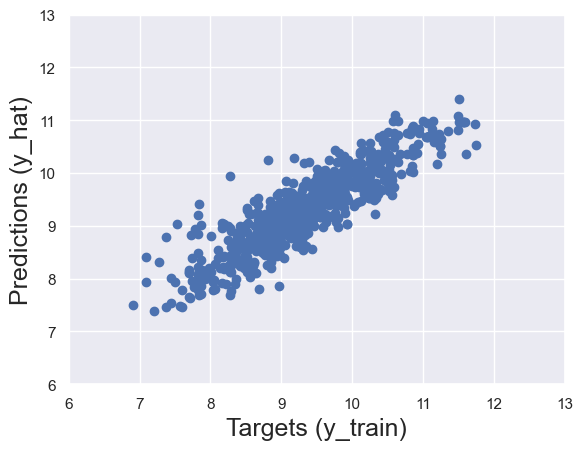

In [67]:
# Comparing the target values and the predicted values
plt.scatter(best_model.y_test, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

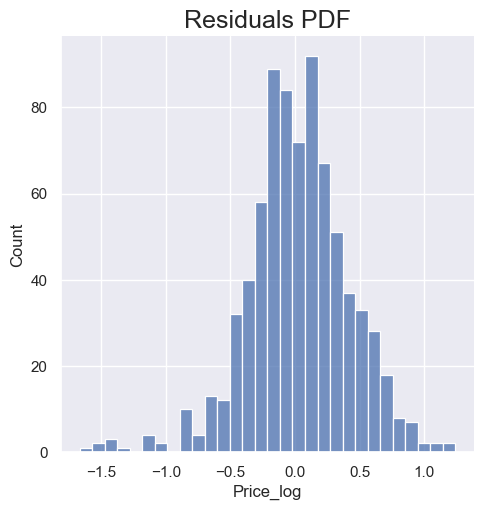

In [68]:
# Residual is the difference between the target values and the predicted values
sns.displot(best_model.y_test - y_hat)
plt.title("Residuals PDF", size=18)

### To deploy

In [69]:
# Features fed to the model
best_features

['Brand_Renault',
 'Brand_Mitsubishi',
 'Body_crossover',
 'Mileage',
 'EngineV',
 'Engine Type_Diesel',
 'Registration_yes']

In [ ]:
# Fake data for testing
dict = {
    'constant' : 1,
    'Brand_Renault' : 0,
    'Brand_Mitsubishi' : 0,
    'Body_crossover' : 0,
    'Mileage' : (340 - mean_mileage) / std_mileage,
    'EngineV' : (2.2 - mean_enginev) / std_enginev,
    'Engine Type_Diesel' : 1,
    'Registration_yes' : 1
}

In [ ]:
# Prediction of logarithmic price
log_predict = best_model.predict(pd.DataFrame(dict, index=[0]))[0]
log_predict

8.78499804682278

In [ ]:
# Convert logarithmic price to an exponential integer
price_predict = int(np.exp(log_predict))
price_predict

6535